# Домашнее задание 3. Детекция объектов

Сыграем в квиддич? Или лучше в карты?

В этом дз вам предстоит написать практически с нуля архитектуру для детекции, а также воспользоваться готовым решением. На выбор даётся два датасета, отличаются они только картинками. Форматы, баллы - все одинаково.

Первый вариант это датасет по кадрам игры в квиддич из Гарри Поттера. Если вы забыли правила, то нажмите [сюда](https://harrypotter.fandom.com/ru/wiki/%D0%9A%D0%B2%D0%B8%D0%B4%D0%B4%D0%B8%D1%87). Вы научитесь искать и выделять на фотографиях бладжеры, квоффл и снитч.

Второй вариант это датасет с игральными картами. Если вы забыли что такое карты, то нажмите [сюда](https://ru.wikipedia.org/wiki/%D0%98%D0%B3%D1%80%D0%B0%D0%BB%D1%8C%D0%BD%D1%8B%D0%B5_%D0%BA%D0%B0%D1%80%D1%82%D1%8B). Вы научитесь искать и выделять на фотографиях несколько типов карт.

Оба варианта содержат около 300 картинок, данные хранятся в xml в формате PascalVOC. Есть малые отличия, но ничего страшного.


Если с самописным детектором совсем не получается, то можно после создания датасетов перейти к концу, где обучается готовый, с ним будет проще :)

# Notes

Дз проверялось на работоспособность в colab. Не гарантируется, что будет работать на чем-то другом, и точно не будет работать из коробки на Windows.

По вопросам формулировок (не ошибок торча!), в случае отсутствия ответа в общем чате (поиск по чату позволяет проверить), можно написать в него с тегом @markblumenau.

## Данные

Скачайте один из датасетов на свой вкус и начните работу с ним.
Разметка находится в xmls папке, картинки в images.

In [ ]:
# Harry Potter -- uncomment
#!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/harry/data.zip

# Cards -- uncomment
!wget https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip



!unzip -q data.zip

--2023-12-01 12:56:46--  https://github.com/markblumenau/hw3_iad_dl/raw/main/cards/data.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip [following]
--2023-12-01 12:56:46--  https://raw.githubusercontent.com/markblumenau/hw3_iad_dl/main/cards/data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38392108 (37M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]  36.61M   191MB/s    in 0.2s    

2023-12-01 12:56:46 (191 MB/s) - ‘data.zip’ saved [38392108/38392108]



# Задача 1. 0.5 балла.

Ниже написан код для стандартного Dataset из библиотеки pytorch. Dataset требует реализации `__getitem__` и `__len__` методов. Далее эти методы будут использованы для формирования батчей для обучения. Поскольку читать придется из xml файлов, нужно перед этим дописать функцию get_xml_data, чтобы по названию картинки подтягивать аннотации.

In [ ]:
import torch
from xml.etree import ElementTree as ET
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2
from pathlib import Path
import glob
import numpy as np
from PIL import Image
import torchvision
from torchvision.models import ResNet50_Weights
from tqdm.notebook import tqdm
from torch import nn
import shutil
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import torch.nn.functional as F

Функции можно и нужно передать некий class_dict. Он есть и при инициализации датасета ниже. С его помощью можно название класса превратить в int. Далее подразумевается, что класс идёт как int.

In [ ]:
def get_xml_data(image_name, root, class_dict, xml_prefix="/xmls/"):
    # get smth like ZZZ/YYY/XXXXXX.jpg -> XXXXXX
    filename = image_name.split("/")[-1].split(".")[0]
    # read xml
    tree = ET.parse(str(root) + xml_prefix + filename + ".xml")
    treeroot = tree.getroot()
    # iterate over bboxes
    bboxes = []
    for member in treeroot.findall("object"):
        # you need: xmin ymin xmax ymax, class in dict
        xmin = int(member.find('bndbox').find('xmin').text)
        ymin = int(member.find('bndbox').find('ymin').text)
        xmax = int(member.find('bndbox').find('xmax').text)
        ymax = int(member.find('bndbox').find('ymax').text)

        class_name = class_dict[member.find('name').text]

        res = (xmin, ymin, xmax, ymax, class_name)

        bboxes.append(res)

    return bboxes

In [ ]:
class PascalDataset(torch.utils.data.Dataset):
    def __init__(self, *, transform, root="dataset", train=True, seed=42):
        self.root = Path(root)
        self.transform = transform

        assert self.root.is_dir(), f"No data at `{root}`"

        self.filenames = np.array(glob.glob(root + "/images/*"))
        with open(str(self.root) + "/class_dict", "r") as f:
            self.class_dict = eval(f.readline())

        self.class_dict_inv = {v: k for k, v in self.class_dict.items()}

        np.random.seed(seed)
        permutation = np.random.permutation(len(self.filenames))

        # Train/test split
        if train:
            self.filenames = self.filenames[
                permutation[: int(len(self.filenames) * 0.9)]
            ].tolist()
        else:
            self.filenames = self.filenames[
                permutation[int(len(self.filenames) * 0.9) :]
            ].tolist()

    def __getitem__(self, idx):

        fname = self.filenames[idx]
        image = np.array(Image.open(fname).convert("RGB"))
        bboxes = get_xml_data(fname, self.root, self.class_dict)

        return self.transform(image=image, bboxes=bboxes)

    def __get_raw_item__(self, idx):
        fname = self.filenames[idx]
        return fname, get_xml_data(fname, self.root, self.class_dict)

    def __len__(self):
        return len(self.filenames)

Ниже определяем стандартные нормализации и приведение размера к 512x512.


In [ ]:
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

train_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.3),
)

test_transform = A.Compose(
    [
        A.Resize(512, 512),
        A.augmentations.transforms.Normalize(mean=mean, std=std),
        ToTensorV2(),
    ],
    bbox_params=dict(format="pascal_voc", min_visibility=0.5),
)

In [ ]:
train_ds = PascalDataset(root="./data/", transform=train_transform, train=True)
test_ds = PascalDataset(root="./data/", transform=test_transform, train=False)

# Задача 2. 1 балл.

Теперь, когда мы загрузили данные, хорошо бы посмотреть на них, прежде чем обучать какие-либо модели. Напишите функцию `visualize`, которая принимает списки изображений и прямоугольников в качестве входных данных и рисует эти прямоугольники на изображениях.

В датасете есть class_dict_inv, который позволит вам сделать обратное преобразование: int, содержащий класс, в строку с названием.


Полезные функции:
* [plt.subplots](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.subplots.html) -- легко создавать несколько изображений в одной pyplot figure
* [ax.imshow](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.imshow.html) -- отображение графиков (не забудьте откатить нормализацию)
* [ax.text](https://matplotlib.org/stable/api/_as_gen/matplotlib.axes.Axes.text.html), [patches.Rectangle](https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html) -- для рисования прямоугольников и текста с аннотацией

In [ ]:
import matplotlib.patches as patches

def visualize(images, bboxes):
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)

    fig, axes = plt.subplots(
        2, len(images) // 2 + len(images) % 2, figsize=(10, 8), dpi=100
    )

    for i, ax in enumerate(axes.reshape(-1)):

        ax.axis(False)

        if i >= len(images):
            break

        img = images[i].permute(1, 2, 0).numpy()
        img = img * std + mean

        ax.imshow(img)

        for bbox in bboxes[i]:
          xmin, ymin, xmax, ymax, class_id = bbox
          class_name = train_ds.class_dict_inv[class_id]

          rect = patches.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, linewidth=1.5, edgecolor='g', facecolor='none')
          ax.add_patch(rect)
          ax.text(xmin, ymin, f"{class_name}", fontsize=10, color="red")

    fig.tight_layout()
    plt.show()

У вас должно получиться что-то похожее на изображения для датасета с масками:

![image](https://gcdnb.pbrd.co/images/n8BnhhfCgYnQ.png)

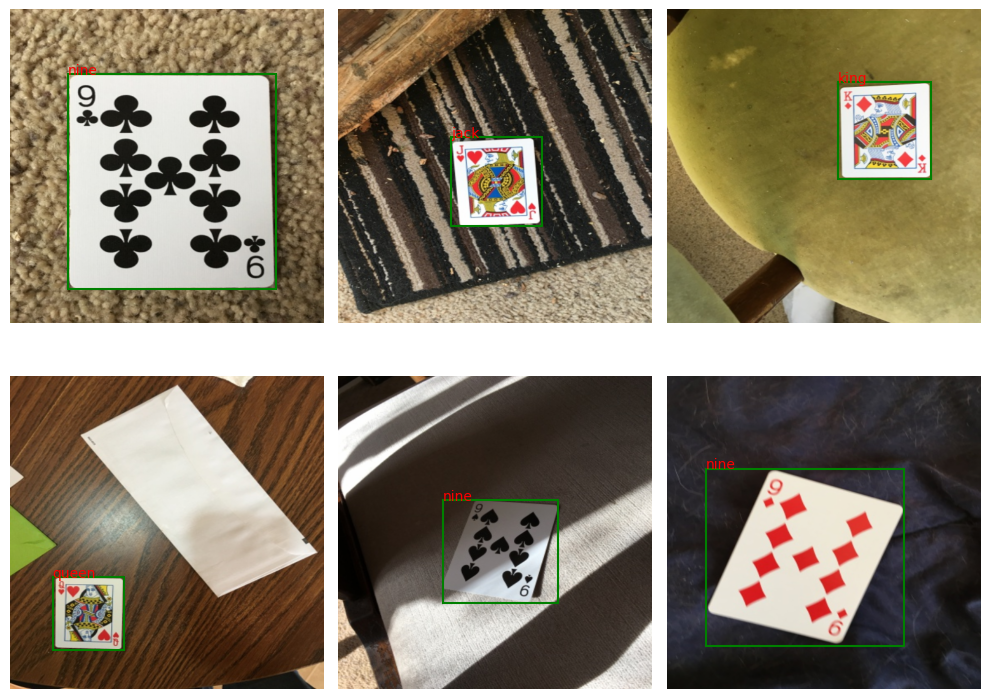

In [ ]:
out = [train_ds[i] for i in range(6)]
visualize([o["image"] for o in out], [o["bboxes"] for o in out])

# Задача 3. 3 балла.
## YOLO-like детектор

Сейчас нам предстоить реализовать детектор, похожий на YOLO. Это один из самых простых детекторов с точки зрения реализации. YOLO описан в статье: [You Only Look Once: Unified, Real-Time Object Detection](https://arxiv.org/abs/1506.02640). Здесь мы его немного изменим и упростим. Будем использовать ResNet для извлечения признаков. На выходе мы будем получать карту признаков размера 16x16.

We convert lists of bounding boxes to the target downsampled grid. For this we

* compute centers of bounding boxes ($c_x, c_y$)
* change center coordinates (offset from the top left corner for each corresponding grid cell on a small grid)
* normalize box height and with to $[0, 1]$
* fill the target grid with values

## Задача 3.1. 1 балл.

Первым делом нам нужно реализовать collate function. Это функция позволит нам кастомизировать, как именно батч конструируется из примеров (смотрите [pytorch docs](https://pytorch.org/docs/stable/data.html#dataloader-collate-fn) для деталей).

Это функция должна принять на вход лист прямоугольников и сгенерировать тензор размера Bx16x16x6. Первая размерность - это количество примеров в батче. Далее идут две пространственные размерности, это сетка 16 на 16.

В каналах у нас будут записаны:
* Сдвиги центра bbox относительно начала клеточки (клеточка это "пиксель" на изображении 16 на 16 на выходе сети). Записаны эти сдвиги будут в клеточку, к которой относятся. 2 канала (X, Y)
* Нормализованные ширина и высота bbox. 2 канала (W, H)
* Confidence сетки. Им мы будем пользоваться, чтобы фильтровать уверенность сетки в наличии bbox в данной клетке. Таргет содержит 1 там, где bbox есть, и 0 иначе. 1 канал
* Класс детекции (тот самый int, полученный из строки с названием)

In [ ]:
def collate_fn(batch, downsample=32):
    imgs, batch_boxes = map(list, (zip(*[(b["image"], b["bboxes"]) for b in batch])))

    imgs = torch.stack(imgs)
    b, _, h, w = imgs.shape

    target = imgs.new_zeros(b, 6, h // downsample, w // downsample)

    # Add sample index to targets
    for i, boxes in enumerate(batch_boxes):
        xmin, ymin, xmax, ymax, classes = map(
            torch.squeeze, torch.split(imgs.new_tensor(boxes), 1, dim=-1)
        )

        # Нормализуйте ширину и высоту, поделив на ширину и высоту исходного изображения
        x_cell = (xmax - xmin)  # TODO размер клетки по X в пикс
        y_cell = (ymax - ymin) # TODO размер клетки по Y в пикс
        w_box =  x_cell / w # TODO ширина бокса отнормированная
        h_box =  y_cell / h # TODO высота бокса отнормированная

        # Посчитайте координаты центра и сдвиги
        cx =  (xmax + xmin) / 2 # TODO (координаты центра в исходных координатах)
        cy =  (ymax + ymin) / 2  # TODO
        cx_idx = cx // downsample # TODO (посчитайте индекс центра на карте признаков размера 16x16. Это будут как раз координаты пикселя, куда мы запишем параметры коробки)
        cy_idx = cy // downsample) # TODO

        cx_box =  (cx % downsample) / downsample # TODO (посчитайте сдивиги относительно cx_idx)
        cy_box =  (cy % downsample) / downsample # TODO

        target[i, :, cy_idx, cx_idx] = torch.stack(
            [cx_box, cy_box, w_box, h_box, torch.ones_like(cx_box), classes]
        )

    return {"image": imgs, "target": target}

Ниже вы можете увидеть пример, как выглядит решетка размера 16 на 16 на исходном изображении:

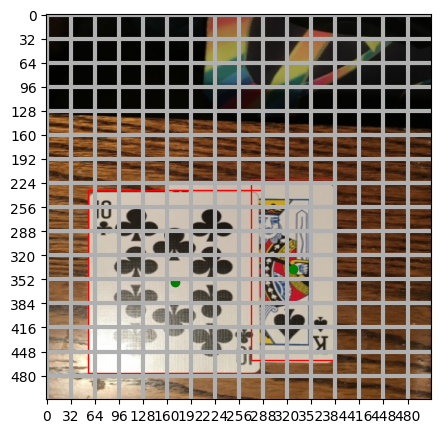

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))
i = 20

img = train_ds[i]["image"].permute(1, 2, 0) * torch.tensor(std).view(
    1, 1, -1
) + torch.tensor(mean).view(1, 1, -1)
bboxes = torch.tensor(train_ds[i]["bboxes"])

ax.imshow(img)
loc = plt.matplotlib.ticker.MultipleLocator(base=32)
ax.xaxis.set_major_locator(loc)
ax.yaxis.set_major_locator(loc)
ax.grid(which="major", axis="both", linestyle="-", linewidth=3)

for bbox in bboxes:
    xmin, ymin, xmax, ymax = bbox[:-1]
    w = xmax - xmin
    h = ymax - ymin
    with_mask = bbox[-1]
    ax.add_patch(Rectangle((xmin, ymin), w, h, fill=False, color="red"))

cx = (bboxes[:, 0] + bboxes[:, 2]) / 2
cy = (bboxes[:, 1] + bboxes[:, 3]) / 2

ax.scatter(cx, cy, color="green", marker="o")

plt.show()

## Задача 3.2. 0.5 балла.

Выход нашей сетки будет несколько больше, чем Bx16x16x6. Почему?

Мы решаем задачу, где классов больше одного. Вспомним прошлое дз: target был одним числом, но выход сетки содержал длинный-длинный вектор, из которого мы получали вероятность принадлежности к тому или иному классу. Здесь то же самое, но как бы в двумерии: у каждой клеточки из этих 16*16 будет свой вектор длины C, который мы будем использовать для определения класса.

Реализуйте обратное относительно collate_fn преобразования, чтобы декодировать выход нейронной сети. Применив функцию decode_prediction к выходу collate function вы должны получить изначальный набор прямоугольников с корректными размерами и координатами, а также классами. Применив к выходу нейросети мы тоже должны получить набор прямоугольников и тоже с корректными классами.

То есть, нужно проделать операции из collate_fn в обратную сторону, но учесть, что у неройнки выход будет чуть длиннее, и там мы должны брать argmax для определения класса.

Hint: в target classes идут в конце. В нейронке они тоже будут в конце, но их будет больше 1. Можно проверять число каналов пришедшего объекта, если оно 6, то перед нами target и надо брать значение, которое записано в клеточке. Иначе (каналов больше 6) перед нами выход нейронки, и надо брать самый вероятный из них.

In [ ]:
def decode_prediction(pred, upsample=32, threshold=0.7):
    b, c, h, w = pred.shape
    img_w, img_h = w * upsample, h * upsample
    ### YOUR CODE HERE ###
    predictions = []

    for i in range(b):
      bboxes = []

      for y in range(h):
          for x in range(w):
              pred_yx = pred[i, :, y, x]

              if pred_yx[4] >= threshold:
                  w_box = pred_yx[3] * img_w
                  h_box = pred_yx[2] * img_h

                  cx_cell = pred_yx[0]
                  cy_cell = pred_yx[1]

                  cx = (cx_cell + x) * upsample
                  cy = (cy_cell + y) * upsample

                  xmin = cx - (w_box / 2)
                  xmax = cx + (w_box / 2)
                  ymin = cy - (h_box / 2)
                  ymax = cy + (h_box / 2)

                  class_pred = pred_yx[5:].numpy()
                  bboxes.append((xmin, ymin, xmax, ymax, np.argmax([class_pred])))

      predictions.append(bboxes)


    return predictions

## Задача 3.3. 1 балл.
Реализуйте модель. Первым делом примените первые 4 блока (до layer4 включительно) ResNet50. Далее добавьте несколько блоков (Conv2D, BatchNorm2D, ReLU). Постепенно уменьшайте количество каналов до 5+C, а размер изображения до 16 на 16. Например, 2048 -> 512 -> 128 -> 32 -> 5+C, где С - количество классов в вашем датасете. Размер ядра при этом 3, паддинг 1. Но вариантов много, попробуйте разные! **Последним слоем обязательно должна быть свертка.** Так как все значения, которые мы предсказываем, находятся в отрезке от 0 до 1 (благодаря нормировке с клеточками), мы после финальной свертки еще применим сигмоиду. Для классов в такой постановке это не навредит.

Если будете фантазировать, то для получения правильного размера изображения после сети не стесняйтесь применять слои с фильтрами больше 3.

In [ ]:
C = 6 # Количество классов в вашем датасете, хоть руками посчитайте, хоть подтяните из словаря классов


class Detector(nn.Module):
    def __init__(self):
        super().__init__()
        model = torchvision.models.resnet50(weights=ResNet50_Weights.DEFAULT)
        ### YOUR CODE HERE ###

        self.resnet_blocks = nn.Sequential(
            model.conv1,
            model.bn1,
            model.relu,
            model.maxpool,
            model.layer1,
            model.layer2,
            model.layer3,
            model.layer4
        )

        self.layers_addition = nn.Sequential(
            nn.Conv2d(2048, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(512, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(128, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 5 + C, kernel_size=3, padding=1)
        )


    def forward(self, img):
        ### YOUR CODE HERE ###

        x = self.resnet_blocks(img)
        x = self.layers_addition(x)
        x = F.interpolate(x, size=(16, 16), mode='bilinear', align_corners=False)
        x = torch.sigmoid(x)

        return x

## Задача 3.4. 0.5 балла.

Реализуйте функцию потерь.

Для этого:
* Сделайте маску, которая будет говорить о положении детектируемых объектов. Её нужно использовать с помощью masked_select (см. доки PyTorch)
* Лосс похож на оригинальный для Yolo V1 и состоит из 4 частей (reduction='sum' для всех)
    - localization loss - Мы берем MSE по координатам бокса там, где есть детектируемый объект
    - box_loss - MSE от корней ширины и высоты bbox там, где есть детектируемый объект
    - classification_loss - Если детектируемый объект есть, то его кросс-энтропия по его классу
    - confidence_loss - Бинарная кросс-энтропия факта наличия объекта ДЛЯ ВСЕХ пикселей. Делается отдельно для детектируемых объектов (вес 1) и для недетектируемых (вес 0.1 например, поскольку их гораздо больше, но можно экспериментировать)


* Ниже есть assert. Если вы экспериментируете с лоссом, он не будет проходить, не обращайте на него внимание. Если будете делать описанное выше, то учтите reduction. Бинарная кросс-энтропия вызывается через BCELoss. Параметр C используется для задачи числа классов. assert написан для 3 классов, в задаче с картами их 6. Подумайте как зависит индексация от параметра C и используйте его.

In [ ]:
def special_loss(pred, target, check=False, C=C):
    ### YOUR CODE HERE ###
    loc_mask = target[:, :2, :, :] > 0
    mask_target = torch.masked_select(target[:, :2, :, :], loc_mask)
    mask_pred = torch.masked_select(pred[:, :2, :, :], loc_mask)
    loss = MSELoss(reduction='sum')

    localization_loss = loss(mask_target, mask_pred)

    box_mask = target[:, 2:4, :, :] > 0
    mask_targetb = torch.masked_select(target[:, 2:4, :, :], box_mask)
    mask_predb = torch.masked_select(pred[:, 2:4, :, :], box_mask)

    box_loss = loss(mask_targetb, mask_predb)

    classification_loss =
    confidence_loss =

    if not check:
        return localization_loss + box_loss + classification_loss + confidence_loss

    else:
        return localization_loss, box_loss, classification_loss, confidence_loss

In [ ]:
# localization box classification confidence - возвращаются в таком порядке, можно сравнить
assert special_loss(torch.zeros((10, 8, 16, 16)), torch.ones((10, 8, 16, 16)), check=True, C=3) == (torch.tensor(5120.), torch.tensor(5120.), torch.tensor(2812.4465), torch.tensor(256000.))

# Задача 4. 2 балла.

Обучите вашу модель (написав цикл обучения), и покажите что она работает (скорее всего, объекты найдутся на 1-2 картинках).

In [ ]:
loader = torch.utils.data.DataLoader(train_ds, 10, collate_fn=collate_fn)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

torch.manual_seed(21)
EPOCHS =  # Harry Potter 20, Cards 15
model = Detector().to(device)
opt = torch.optim.AdamW(model.parameters(), lr=1e-3)

for e in tqdm(range(EPOCHS)):
    pbar = tqdm(loader, leave=False)
    epoch_losses = []
    for batch in pbar:
        ### YOUR CODE HERE ###


    print(f"Epoch {e} done; Train loss {np.mean(epoch_losses):.3f};")

Запустим обученный детектор на тестовых изображениях:

In [ ]:
test_loader = torch.utils.data.DataLoader(test_ds, 6, collate_fn=collate_fn)
i = iter(test_loader)
batch = next(i)

In [ ]:
# Нужно сделать предсказание и переложить результат на cpu

### YOUR CODE HERE ###

In [ ]:
# Сделайте визуализацию. Поиграйтесь с threshold, скорее всего нужно понизить до ~0.1

### YOUR CODE HERE ###

Результат сильно так себе, да? Есть множество вариантов улучшений, самый простой из которых это приделать к выходу [NMS](https://paperswithcode.com/method/non-maximum-suppression#:~:text=Non%20Maximum%20Suppression%20is%20a,below%20a%20given%20probability%20bound.). Если хочется, можно почитать про YOLO v1 [тут](https://arxiv.org/abs/1506.02640).

# Задача 5. 3.5 балла.

Займёмся более простыми вещами. Возьмем готовую архитектуру, обучим её на наших данных и посмотрим.

Для этого будем использовать YOLO v8 от ultralytics.

In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 646.6/646.6 kB 5.6 MB/s eta 0:00:00


## Задача 5.1. 1.5 балла.

Чтобы дальше модель обучалась одной строкой, данные нужно переложить в правильный формат. Да-да, классика перекладывания JSON. Как правильно паковать можно посмотреть [тут](https://roboflow.com/formats/yolov8-pytorch-txt).

Если коротко:
* Есть .yaml, где живут пути к папкам с картинками, количество классов и их названия
* Есть папочки train valid (их поможем вам собрать), в них две подпапки:
    - Первая images, в ней лежат картинки
    - Вторая labels, в ней лежат файлы с названиями как у картинок, но вместо расширения картинок нужен .txt, внутри формат как описан на Roboflow


In [ ]:
# Делаем папочки
!rm -rf train
!rm -rf valid
!mkdir -p train/images train/labels valid/images valid/labels

Реализуйте функцию, которая принимает аннотации в изначальном формате, а возвращает их в нужном для YOLO v8. Это должен быть массив готовых строк, которые можно сразу забрасывать в файлик, добавив \n.

In [ ]:
def annotation2txt(bboxes, w_im, h_im):
    ### YOUR CODE HERE ###
    output = []
    for bbox in bboxes:
      xmin, ymin, xmax, ymax, class_name = bbox
      cx = ((xmin + xmax) / 2) / w_im
      cy = ((ymin + ymax) / 2) / h_im
      w_box =  (xmax - xmin) / w_im
      h_box =  (ymax - ymin) / h_im

      output.append(f'{class_name} {cx} {cy} {w_box} {h_box}')

    return output

In [ ]:
# Копируем картиночки по папочкам и создаем txt файлики

for i in range(len(train_ds)):
    result = train_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./train/images/" + result[0].split("/")[-1],
    )

    h_im, w_im, ch = np.array(Image.open(result[0])).shape
    with open(
        "./train/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

for i in range(len(test_ds)):
    result = test_ds.__get_raw_item__(i)

    shutil.copyfile(
        result[0], "./valid/images/" + result[0].split("/")[-1],
    )

    with open(
        "./valid/labels/" + result[0].split("/")[-1].split(".")[0] + ".txt",
        "w",
        encoding="utf8",
    ) as f:
        f.write("\n".join(annotation2txt(result[1], w_im, h_im)))

In [ ]:
# Собираем YAML

nc =  6 # Укажите число классов. Хоть руками, хоть по-умному посчитайте (см. class_dict)
names =  ["king", "jack", "ace", "ten", "nine", "queen"] # Укажите имена классов. Хоть руками, хоть по-умному посчитайте, это массив строк (см. class_dict)

with open("data.yaml", "w") as f:
    f.write(f"train: ../train/images\nval: ../valid/images\n\nnc: {nc}\nnames: {names}")

## Задание 5.2. 1.5 балла.

Обучите модель YOLO v8 самого маленького размера. Библиотека максимально friendly, от вас требуется написать две строчки. Модель нужно взять необученную!

Подсказка: подумайте зачем вам data.yaml и что такое yolov8n.yaml (не стесняйтесь гуглить)

In [ ]:
from ultralytics import YOLO

model = YOLO('yolov8n.yaml')

results = model.train(data='data.yaml', epochs=20, imgsz=640, batch=8, name='yolov8n_custom')


                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics.nn.modules.conv.Conv             [128

100%|██████████| 755k/755k [00:00<00:00, 15.5MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 6.23M/6.23M [00:00<00:00, 77.8MB/s]


AMP: checks passed ✅


train: Scanning /content/train/labels... 326 images, 0 backgrounds, 0 corrupt: 100%|██████████| 326/326 [00:00<00:00, 1794.05it/s]

train: New cache created: /content/train/labels.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/valid/labels... 37 images, 0 backgrounds, 3 corrupt: 100%|██████████| 37/37 [00:00<00:00, 1911.88it/s]

val: WARNING ⚠️ /content/valid/images/cam_image21.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.1574]
val: WARNING ⚠️ /content/valid/images/cam_image23.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.0622]
val: WARNING ⚠️ /content/valid/images/cam_image36.jpg: ignoring corrupt image/label: non-normalized or out of bounds coordinates [     1.5357       1.537]
val: New cache created: /content/valid/labels.cache


Plotting labels to runs/detect/yolov8n_custom/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/yolov8n_custom
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      1.46G          3      4.614      4.346         27        640: 100%|██████████| 41/41 [00:11<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  1.83it/s]

                   all         34         61     0.0011      0.212    0.00147   0.000345



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      1.34G      2.943      4.149      4.016         24        640: 100%|██████████| 41/41 [00:08<00:00,  5.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  3.00it/s]

                   all         34         61    0.00106      0.191    0.00142   0.000322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      1.34G      2.866       3.93      3.703         21        640: 100%|██████████| 41/41 [00:07<00:00,  5.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.58it/s]


                   all         34         61     0.0035      0.418     0.0344     0.0088

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      1.34G      2.782      3.679      3.499         19        640: 100%|██████████| 41/41 [00:09<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.88it/s]


                   all         34         61      0.107     0.0764     0.0682     0.0217

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      1.34G      2.721      3.539       3.38         28        640: 100%|██████████| 41/41 [00:08<00:00,  5.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:01<00:00,  2.74it/s]

                   all         34         61      0.538     0.0722     0.0807     0.0321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      1.34G      2.638      3.402      3.247         26        640: 100%|██████████| 41/41 [00:07<00:00,  5.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.85it/s]

                   all         34         61     0.0645      0.359      0.145      0.056



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      1.34G      2.502      3.292      3.131         21        640: 100%|██████████| 41/41 [00:09<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         34         61      0.074      0.282      0.104      0.037



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      1.34G      2.367      3.091      3.004         21        640: 100%|██████████| 41/41 [00:07<00:00,  5.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.70it/s]

                   all         34         61      0.221      0.368      0.239      0.103



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      1.34G      2.332      3.103      2.958         23        640: 100%|██████████| 41/41 [00:08<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.83it/s]

                   all         34         61      0.322      0.439      0.324      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      1.34G      2.187      2.879      2.791         22        640: 100%|██████████| 41/41 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.14it/s]

                   all         34         61      0.401      0.389      0.295      0.163


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      1.48G      1.702      3.173      2.422         10        640: 100%|██████████| 41/41 [00:07<00:00,  5.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.49it/s]


                   all         34         61      0.521      0.407       0.34      0.176

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      1.34G      1.615      2.939      2.316          7        640: 100%|██████████| 41/41 [00:08<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.82it/s]

                   all         34         61      0.507      0.326      0.366      0.188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      1.34G       1.62      2.897      2.318          9        640: 100%|██████████| 41/41 [00:07<00:00,  5.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.03it/s]

                   all         34         61      0.358      0.514      0.369      0.205



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      1.34G      1.472      2.692      2.187         18        640: 100%|██████████| 41/41 [00:07<00:00,  5.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  6.91it/s]

                   all         34         61      0.344      0.435      0.398      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      1.34G      1.467      2.651      2.166         14        640: 100%|██████████| 41/41 [00:08<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]

                   all         34         61      0.344      0.502      0.424      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      1.34G      1.396      2.531      2.061          9        640: 100%|██████████| 41/41 [00:06<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.47it/s]

                   all         34         61       0.39      0.421      0.423      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      1.34G      1.361      2.429      2.051         11        640: 100%|██████████| 41/41 [00:08<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.58it/s]

                   all         34         61       0.36      0.606      0.507      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      1.34G      1.366      2.426      2.016         13        640: 100%|██████████| 41/41 [00:07<00:00,  5.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.79it/s]

                   all         34         61       0.41      0.609      0.486      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      1.34G      1.311      2.387      1.988          7        640: 100%|██████████| 41/41 [00:07<00:00,  5.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.78it/s]

                   all         34         61      0.403       0.64      0.483      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      1.34G      1.312       2.34      1.986          8        640: 100%|██████████| 41/41 [00:08<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.77it/s]

                   all         34         61      0.445       0.64       0.53      0.348



20 epochs completed in 0.054 hours.
Optimizer stripped from runs/detect/yolov8n_custom/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/yolov8n_custom/weights/best.pt, 6.2MB

Validating runs/detect/yolov8n_custom/weights/best.pt...
Ultralytics YOLOv8.0.221 🚀 Python-3.10.12 torch-2.1.0+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8n summary (fused): 168 layers, 3006818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.84it/s]


                   all         34         61      0.445       0.64       0.53      0.347
                  king         34         11      0.336      0.636      0.381      0.229
                  jack         34          8      0.363          1      0.674        0.5
                   ace         34         12      0.755      0.514      0.632      0.321
                   ten         34         10      0.514        0.6      0.725      0.546
                  nine         34         12      0.411      0.467      0.446      0.304
                 queen         34          8      0.292      0.625      0.321      0.183
Speed: 0.3ms preprocess, 3.8ms inference, 0.0ms loss, 2.8ms postprocess per image
Results saved to runs/detect/yolov8n_custom


## Задание 5.3. 0.5 балла.

Как-нибудь отрисуйте предсказания на валидационной выборке (хотя бы части из 5-10 картинок).

Здесь можно использовать костыли с параметром save=True у predict, потом прочитать их чем-нибудь, отрисовать матплотлибом. Есть варианты и получше. Дефолтный show будет пытаться показывать через opencv imshow, он в коллабе работать не будет.

In [ ]:
model = YOLO('./runs/detect/yolov8n_custom/weights/best.pt')

source = './valid/images/'

# Выполнить вывод на источник
results = model(source, save=True)



image 1/37 /content/valid/images/IMG_2389.JPG: 640x480 1 king, 14.4ms
image 2/37 /content/valid/images/IMG_2395.JPG: 640x480 1 ten, 10.4ms
image 3/37 /content/valid/images/IMG_2401.JPG: 640x480 1 jack, 8.0ms
image 4/37 /content/valid/images/IMG_2404.JPG: 640x480 1 king, 1 jack, 1 queen, 8.3ms
image 5/37 /content/valid/images/IMG_2431.JPG: 640x480 1 king, 1 jack, 8.4ms
image 6/37 /content/valid/images/IMG_2432.JPG: 640x480 1 nine, 8.1ms
image 7/37 /content/valid/images/IMG_2433.JPG: 640x480 (no detections), 7.5ms
image 8/37 /content/valid/images/IMG_2467.JPG: 640x480 (no detections), 7.7ms
image 9/37 /content/valid/images/IMG_2476.JPG: 640x480 (no detections), 7.8ms
image 10/37 /content/valid/images/IMG_2491.JPG: 640x480 1 jack, 7.7ms
image 11/37 /content/valid/images/IMG_2517.JPG: 640x480 2 aces, 9.0ms
image 12/37 /content/valid/images/IMG_2518.JPG: 640x480 (no detections), 8.3ms
image 13/37 /content/valid/images/IMG_2528.JPG: 640x480 1 ace, 1 ten, 9.2ms
image 14/37 /content/valid/ima

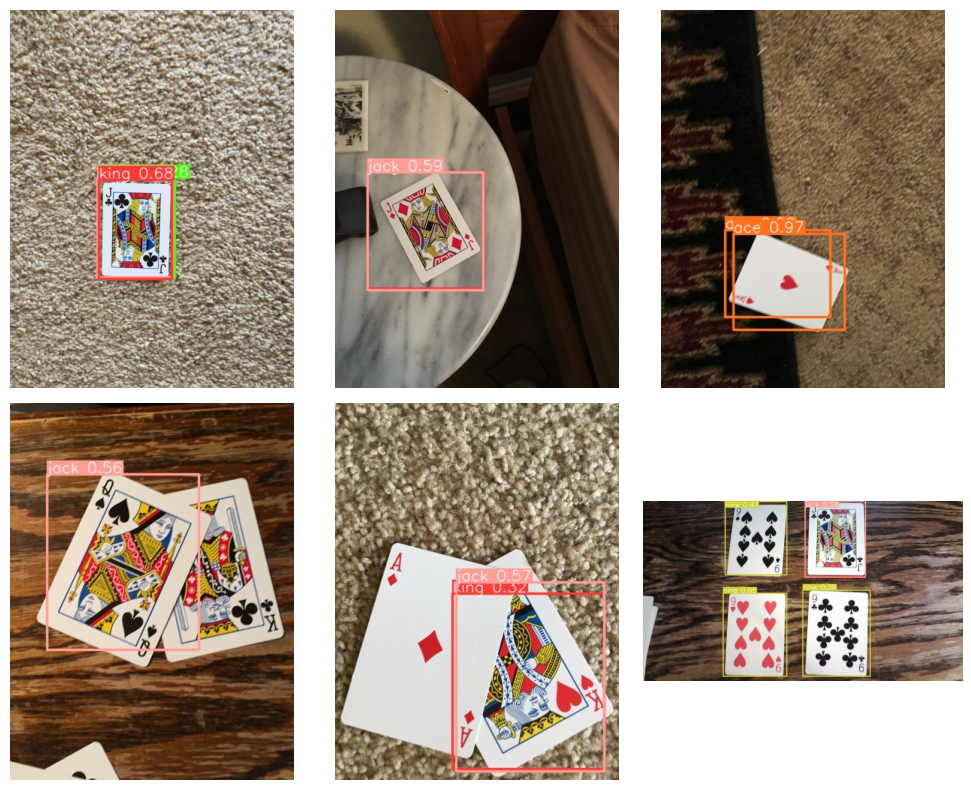

In [ ]:
import cv2
imgs = ['IMG_2404.JPG', 'IMG_2431.JPG', 'IMG_2517.JPG', 'IMG_2628.JPG', 'IMG_2640.JPG', 'cam_image36.jpg']

fig, axes = plt.subplots(2, 3, figsize=(10, 8), dpi=100)

for i, ax in enumerate(axes.reshape(-1)):

    ax.axis(False)

    img = cv2.imread('./runs/detect/predict/'+imgs[i])
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    ax.imshow(img)


fig.tight_layout()
plt.show()

#Материалы#

* https://www.kaggle.com/code/gokifujiya/face-mask-object-detection-with-xml-file

* https://matplotlib.org/stable/api/_as_gen/matplotlib.patches.Rectangle.html

* https://docs.ultralytics.com/

* Семинарские занятия
